# Programming Project - INF442

## $ P1 : Power-Consumption-Weather $

#### Author:
$\bullet$ Clara Rita Nassif

$\bullet$ Xavier Leprintemps Lekeuka Fouelefack

In [32]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 #try it soft with querries
import datetime
from scipy import stats
from scipy import interpolate
import seaborn as sns
import sys
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from scipy.stats import kstest,norm



%matplotlib inline

### Buiding the dataset

In [33]:
#### Building dataset

## weather data
weather_data = pd.DataFrame()
for i in [7,8,9,10]:
    for j in range(1,13):
        fname = "data/weather/synop.20{:02d}{:02d}.csv".format(i,j)
        df = pd.read_csv(fname, delimiter = ';', na_values = ['mq'])
        df_orly = df.loc[df["numer_sta"]==7149].copy()  ##Save only orly's data
        weather_data = pd.concat([weather_data,df_orly]).reset_index(drop = True)

### Household Consumption data
power_data = pd.DataFrame()
columns = ['date','time','global_active_power','global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']
for i in [7,8,9,10]:
    fname = "data\household_power_consumption\household_power_consumption_20{:02d}.csv".format(i)
    df = pd.read_csv(fname, sep = ";",names = columns, na_values=['?'])
    power_data = pd.concat([power_data,df]).reset_index(drop = True)
    

In [34]:
print("\n   ####### Sample of power data  #######")
power_data.sample(5)


   ####### Sample of power data  #######


,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
48758,3/2/2007,20:38:00,3.134,0.366,234.89,13.4,1.0,0.0,17.0
217708,1/6/2007,04:28:00,0.306,0.072,235.05,1.4,0.0,0.0,0.0
1251811,19/5/2009,07:31:00,1.986,0.000,241.37,8.2,0.0,0.0,18.0
11612,9/1/2007,01:32:00,0.386,0.272,240.67,2.0,0.0,2.0,0.0
1257795,23/5/2009,11:15:00,1.616,0.328,237.67,6.8,0.0,0.0,18.0


In [35]:
print("\n  #######  Sample of Weather data  ######")
weather_data.sample(5)


  #######  Sample of Weather data  ######


,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
6684,7149,20090417060000,100980.0,50.0,3.0,290.0,2.6,280.75,279.35,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3458,7149,20080309120000,100060.0,-150.0,8.0,190.0,7.2,281.65,280.25,91.0,...,7.0,6.0,390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4579,7149,20080728030000,101430.0,-90.0,6.0,0.0,0.0,292.85,290.95,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5443,7149,20081113030000,102470.0,80.0,3.0,270.0,1.0,275.45,275.15,98.0,...,7.0,6.0,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1363,7149,20070620180000,101350.0,-90.0,8.0,170.0,3.1,295.65,283.75,47.0,...,3.0,0.0,7500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Data Preprocessing



In [36]:
#### Preprocessing 

### POWER DATA

# Restructuring the dataset into To Time series for easier handling
data = power_data.copy(deep = True)
data['date'] = data['date'] + " " + data['time']
data['date'] = pd.to_datetime(data['date'], format = '%d/%m/%Y %H:%M:%S')
data = data.set_index(data['date'])
data.drop(['date','time'],inplace = True, axis = 1)


In [37]:
# Outliers detection with zscore and Interpolation
treshold = 3
print(f"\n percentage of rows with missing values: {data.isnull().all(axis = 1).sum()*100/power_data.shape[0]:1.03}%")

zscore = (data-data.mean())/data.std()
outliers = (np.abs(zscore) > treshold).any(axis = 1)
print(f"\n Percentage of outliers detected in the dataset: {outliers.sum()*100/power_data.shape[0]:1.03}% . ")
print(f"\n This looks pretty much, we'll make an analyse to decide what to do with these outliers")

# What to do with outliers ? (remove or replace with interpolate values from non outliers)

    ## First idea: Discard them

data1 = data[~outliers]
data1 = data1.interpolate(method = 'linear', axis = 0)
    ## second idea: replace with interpolate values from non outliers
data2 = data.copy(deep = True)
data2[np.abs(zscore) > treshold] = np.nan
data2 = data2.interpolate(method = 'linear', axis = 0)




 percentage of rows with missing values: 1.27%

 Percentage of outliers detected in the dataset: 6.52% . 

 This looks pretty much, we'll make an analyse to decide what to do with these outliers


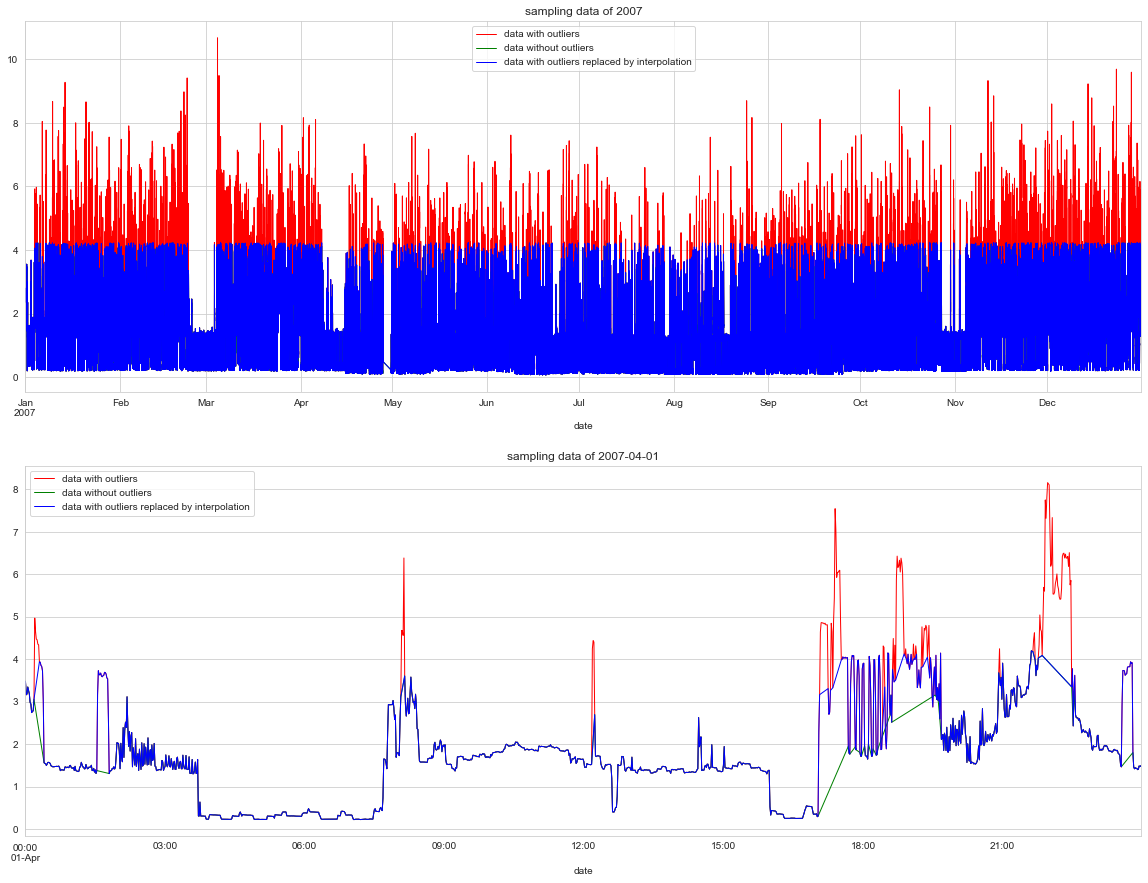

In [38]:
## Visualisation

plt.figure(figsize = (20,15))
plt.subplot(211)

sns.set_style("whitegrid")
data.loc['2007']['global_active_power'].plot(linewidth = 1, color = 'red', label = "data with outliers")
(data1.loc['2007']['global_active_power']).plot(linewidth = 1, color = 'green', label = "data without outliers")
data2.loc['2007']['global_active_power'].plot(linewidth = 1, color = 'blue', label = "data with outliers replaced by interpolation")

plt.title("sampling data of 2007")
plt.legend(loc = 'best')

plt.subplot(212)

sns.set_style("whitegrid")
data.loc['2007-04-01']['global_active_power'].plot(linewidth = 1, color = 'red', label = "data with outliers")
(data1.loc['2007-04-01']['global_active_power']).plot(linewidth = 1, color = 'green', label = "data without outliers")
(data2.loc['2007-04-01']['global_active_power']).plot(linewidth = 1, color = 'blue', label = "data with outliers replaced by interpolation")

plt.title("sampling data of 2007-04-01")
plt.legend(loc = 'best')
plt.show()


###### Comment 
The first plot shows us that data with outliers has the same global trend as data without them, but frequently gives single too far values. Meanwhile, the second plot that is more refined permits to see that we lose an amount of information when we just discard outliers: 
- The green plot appears to have straigth discontinous lines where the blue one keeps a continous trend. 
- Dataset without outliers also removes a lot of timestamps in our dataset, which can have a non negligeable effect when integrating the weather data for analysis. 

$\text{According to this, we will finally we'll keep the data in which we replaced the outliers values by their interpolation}$


 	 +++++ Correlation matrix between features +++++


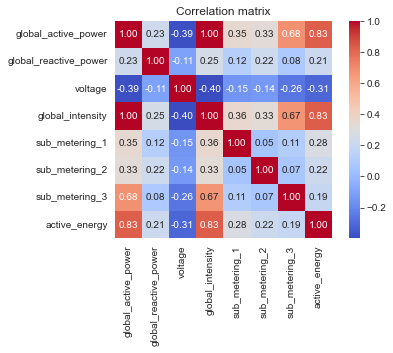

In [39]:
# Adding active_energy column
data = data2.copy(deep = True)
data['active_energy'] = data['global_active_power']*100/6 - data['sub_metering_1'] - data['sub_metering_2'] - data['sub_metering_3']

# Unecessary data removing 'correlation approach'
plt.figure()
corr_mat = data.corr()
print("\n \t +++++ Correlation matrix between features +++++")
sns.heatmap(corr_mat, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.title("Correlation matrix")
plt.show()


According to the matrix, 'global_active_power' and 'global_intensity' are too highly correlated (corr = 1.0) ; We can keep only one of them

In [40]:
data.drop(['global_intensity'], inplace = True, axis = 1 )

In [41]:
print("\n \t +++++ Sample of cleaned Power data ++++++")
power_data = data.copy(deep = True)
power_data.sample(5)


 	 +++++ Sample of cleaned Power data ++++++


,global_active_power,global_reactive_power,voltage,sub_metering_1,sub_metering_2,sub_metering_3,active_energy
date,,,,,,,
2009-02-13 02:28:00,0.336,0.122,245.89,0.0,0.0,0.0,5.600000
2009-04-03 17:01:00,0.266,0.000,240.46,0.0,0.0,0.0,4.433333
2009-10-19 18:30:00,1.920,0.104,244.00,0.0,0.0,19.0,13.000000
2009-10-17 03:36:00,0.332,0.090,242.64,0.0,0.0,0.0,5.533333
2010-02-04 14:00:00,1.436,0.098,243.91,0.0,0.0,18.0,5.933333


In [42]:
### Weather Data
data = weather_data.copy(deep = True)

#Restructuring the dataset into To Time series for easier handling
data['date'] = pd.to_datetime(data['date'], format = '%Y%m%d%H%M%S' )
data = data.set_index(data['date'])
data.drop(['date','numer_sta'], inplace = True, axis = 1)


In [43]:
# Checking for missing values rows
print(f"\n Number of empty rows: {data.isnull().all(axis = 1).sum()} ")
print(f"\n Percentage of rows with at least one missing value: {data.isnull().any(axis = 1).sum()*100/weather_data.shape[0]}% ")
print("Some rows have a lot of missing values, hence are not relevant for our analysis given that even interpolation can't be accurate")
data['ht_neige'].fillna(0, inplace = True)
data.dropna(thresh = 0.6*data.shape[0], inplace = True, axis = 1) # discard each column with more than 60% of missing value

#Handling Outliers

zscore = (data-data.mean())/data.std()
outliers = (np.abs(zscore)>treshold).any(axis = 1)
print(f"\n Percentage of outliers detected in the dataset : {outliers.sum()*100/weather_data.shape[0]:1.03} %")

data[np.abs(zscore)>treshold] = np.nan

# Filling missing values, interpolation
data = data.interpolate(method = 'linear')
data.fillna(method  ='bfill', inplace =True)



 Number of empty rows: 0 

 Percentage of rows with at least one missing value: 100.0% 
Some rows have a lot of missing values, hence are not relevant for our analysis given that even interpolation can't be accurate

 Percentage of outliers detected in the dataset : 9.28 %


In [44]:
print("\n \t+++++ Sample of cleaned Weather data +++++")
weather_data = data
weather_data.head(5)


 	+++++ Sample of cleaned Weather data +++++


,pmer,tend,cod_tend,dd,ff,t,td,u,vv,ww,...,ssfrai,perssfrai,rr1,rr3,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,101960.0,-70.0,6.0,220.0,9.8,286.65,284.85,89.0,20000.0,0.0,...,0.0,-60.0,0.0,1.0,710.0,1114.0,3100.0,2.0,8.0,780.0
2007-01-01 03:00:00,102010.0,40.0,3.0,240.0,7.2,285.65,282.25,80.0,20000.0,0.0,...,0.0,-60.0,0.0,0.2,710.0,1114.0,3100.0,2.0,8.0,780.0
2007-01-01 06:00:00,102040.0,30.0,3.0,230.0,8.7,283.65,279.75,77.0,20000.0,2.0,...,0.0,-60.0,0.0,0.0,710.0,1114.0,3100.0,2.0,8.0,780.0
2007-01-01 09:00:00,102240.0,190.0,3.0,250.0,9.8,282.05,278.05,76.0,17000.0,25.0,...,0.0,-30.0,0.4,0.4,710.0,1114.0,3100.0,2.0,8.0,450.0
2007-01-01 12:00:00,102450.0,210.0,0.0,270.0,8.7,283.65,276.65,62.0,25000.0,3.0,...,0.0,-60.0,0.0,0.0,710.0,1114.0,3100.0,1.0,8.0,840.0


In [45]:
###### Integrating the two datasets

d1 = weather_data.copy(deep = True)
d2 = power_data.copy(deep =True)

d1 = d1.loc[:'2010-11-26 21:00']
d2 = d2.loc[:'2010-11-26 21:00']
d1 = d1.asfreq('T', method = 'nearest')

data = pd.concat([d2,d1], axis = 1)

In [46]:
print("\n \t+++++ Sample of the whole dataset +++++")
data.sample(5)


 	+++++ Sample of the whole dataset +++++


,global_active_power,global_reactive_power,voltage,sub_metering_1,sub_metering_2,sub_metering_3,active_energy,pmer,tend,cod_tend,...,ssfrai,perssfrai,rr1,rr3,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1
date,,,,,,,,,,,,,,,,,,,,,
2008-01-27 06:36:00,0.312,0.076,242.83,0.0,0.0,0.0,5.200000,103740.0,10.0,3.0,...,0.0,-60.0,0.0,0.0,710.0,1103.0,3100.0,3.00,0.0,7500.0
2008-05-26 15:04:00,0.436,0.162,244.41,0.0,0.0,0.0,7.266667,100740.0,-80.0,8.0,...,0.0,-30.0,1.0,1.0,710.0,1106.0,3100.0,1.00,8.0,630.0
2008-10-23 16:32:00,0.774,0.216,239.63,0.0,1.0,1.0,10.900000,102560.0,-80.0,6.0,...,0.0,-60.0,0.0,0.0,710.0,1103.0,3100.0,3.00,0.0,7500.0
2008-11-02 02:06:00,0.532,0.096,245.74,0.0,0.0,0.0,8.866667,101180.0,190.0,1.0,...,0.0,-30.0,0.0,0.0,710.0,1109.0,3100.0,4.00,6.0,390.0
2008-01-31 04:12:00,0.326,0.000,243.57,0.0,0.0,0.0,5.433333,102930.0,-170.0,8.0,...,0.0,-60.0,0.0,0.0,710.0,1102.0,3100.0,1.75,6.5,712.5


## 2. Seasonality detection

###### Getting Insights with some plots


 Globally 



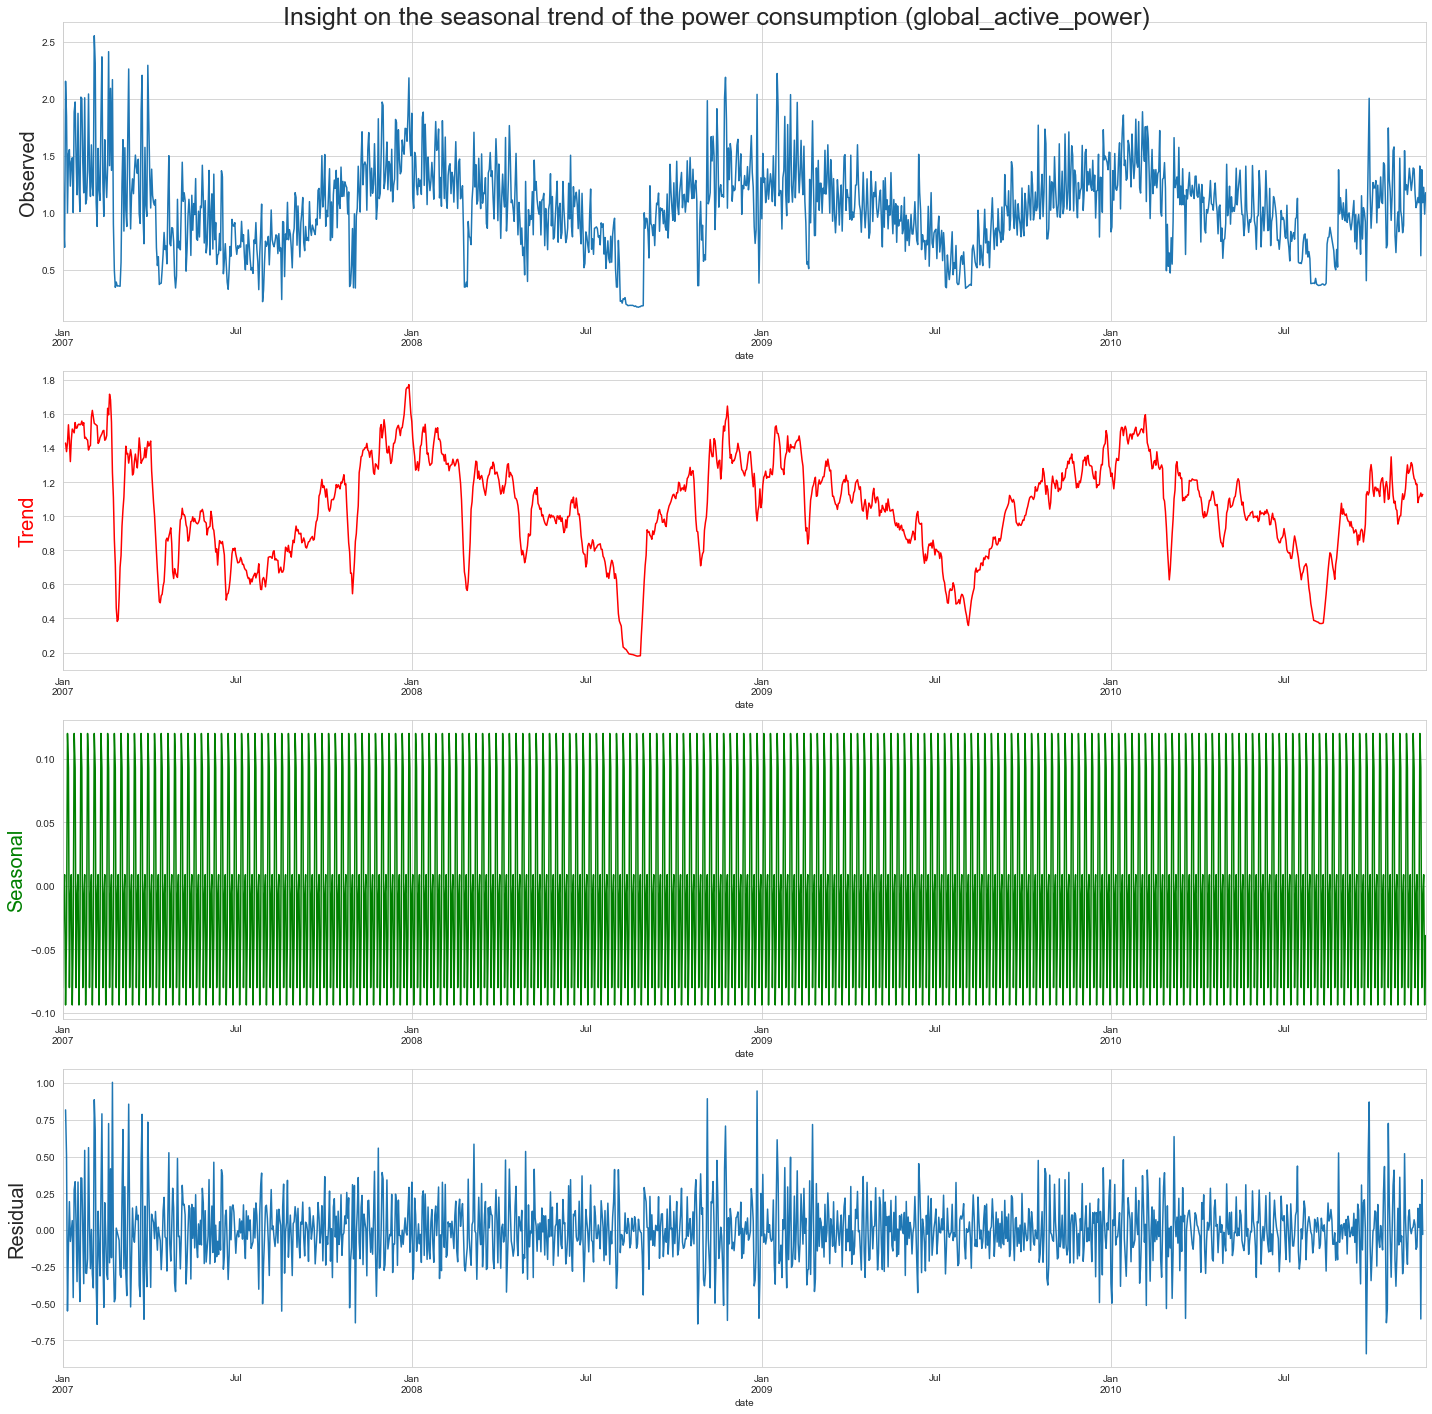


 In a single year : 2009 



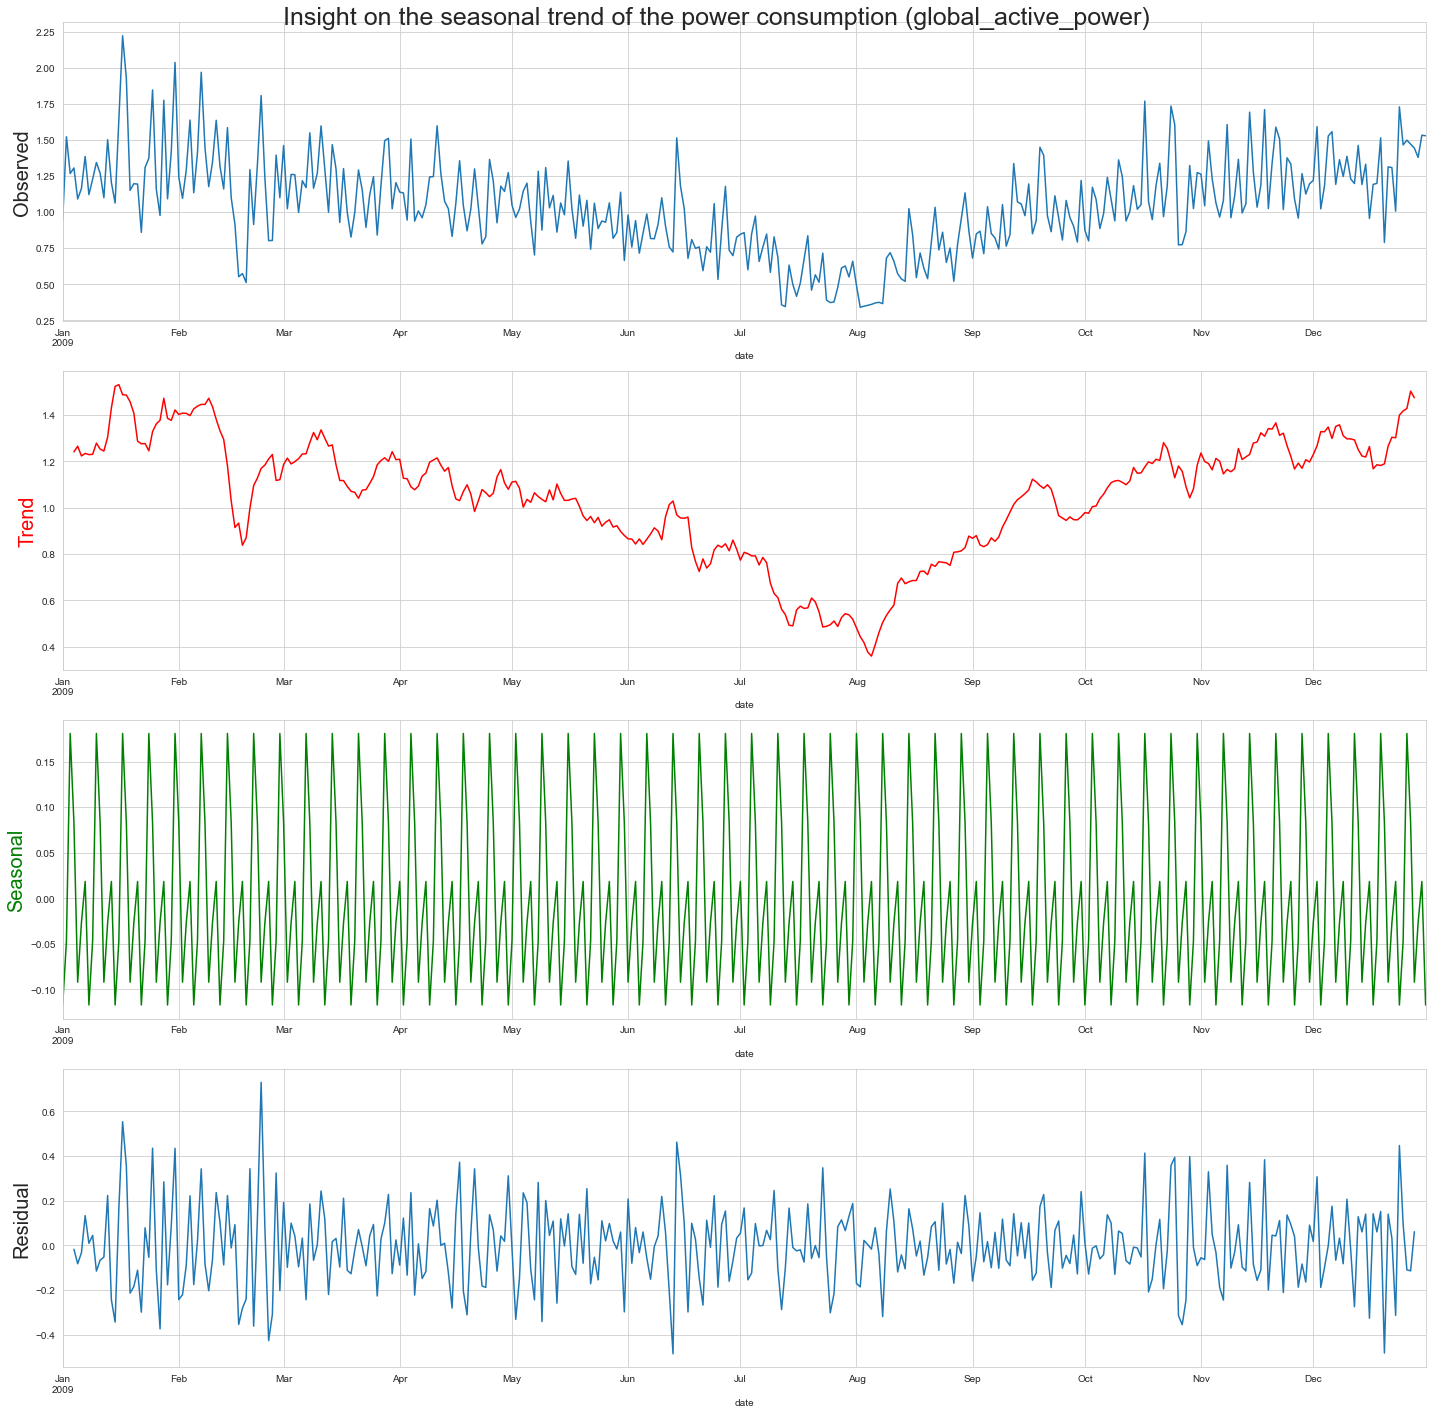

In [47]:

import statsmodels.api as sm

df = data.copy(deep =True)
d_day = df.resample('D').mean()
var = 'global_active_power'
year = '2009'


# Plot the decomposition results
def season() :
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20))
    decomposition.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed',fontsize = 20)
    decomposition.trend.plot(ax=ax2,color = 'red')
    ax2.set_ylabel('Trend',fontsize = 20,color = 'red')
    decomposition.seasonal.plot(ax=ax3, color = 'green')
    ax3.set_ylabel('Seasonal',fontsize = 20,color = 'green')
    decomposition.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual',fontsize = 20)
    fig.suptitle(f'Insight on the seasonal trend of the power consumption ({var})', fontsize = 25)
    plt.tight_layout()
    plt.show()
    
print('\n Globally \n')
decomposition = sm.tsa.seasonal_decompose(d_day[var])
season()

print(f'\n In a single year : {year} \n')
decomposition = sm.tsa.seasonal_decompose(d_day.loc[year][var])
season()




##### Comment: 

- Consumption seems to have a repetitive trend: Starts high at the begining of the year, decreases till mid-year and increases till the end of the year 
- It appears to be a seasonal repetition of the consumptions throw each month of the year

### K-means Clustering

In [48]:
cols = d_day.columns[:7]

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


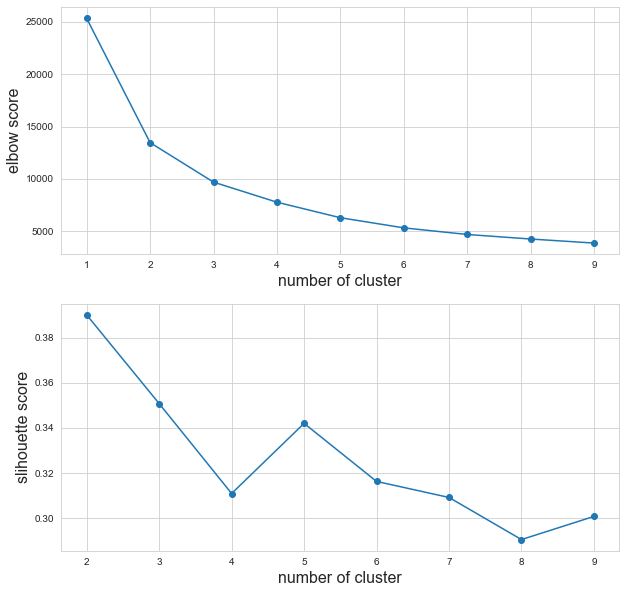

The elbow and silhoutte methods brings us to take 2 as the best number of clusters


In [49]:
####

## Scaling/standardizing

def d_scale(d,how = 'none'):
    if how == 'minmax': return MinMaxScaler().fit_transform(d)
    if how == 'std' : return StandardScaler().fit_transform(d)
    if how == 'minmax2': return MinMaxScaler(feature_range = (-1,1)).fit_transform(d)
    else: return d

### Clustering

#Optimizing the number of Clusters
def optimise_k (data, max_nb_clust=10):
    km = [KMeans(n_clusters = i).fit(df) for i in range(1,max_nb_clust)]
    labels = [km[i].labels_ for i in range(max_nb_clust-1)]
    score = [km[i].inertia_ for i in range(max_nb_clust-1)]
    sil = [silhouette_score(data,labels[i]) for i in range(1,max_nb_clust-1)]
    
    fig,(ax1,ax2) = plt.subplots(2,1,figsize = (10,10))
    ax1.plot(np.arange(1,max_nb_clust),score, 'o-')
    ax1.set_xlabel('number of cluster',fontsize=16)
    ax1.set_ylabel('elbow score',fontsize=16)
    ax1.grid(True)
    
    ax2.plot(np.arange(2,max_nb_clust),sil, 'o-')
    ax2.set_xlabel('number of cluster',fontsize=16)
    ax2.set_ylabel('slihouette score',fontsize=16)
    ax2.grid(True)
    
    plt.show()
df = d_scale(d_day.loc['2007':'2008'][cols])
max_k = 10
optimise_k(df,max_k)
print("The elbow and silhoutte methods brings us to take 2 as the best number of clusters")

<function matplotlib.pyplot.show(close=None, block=None)>

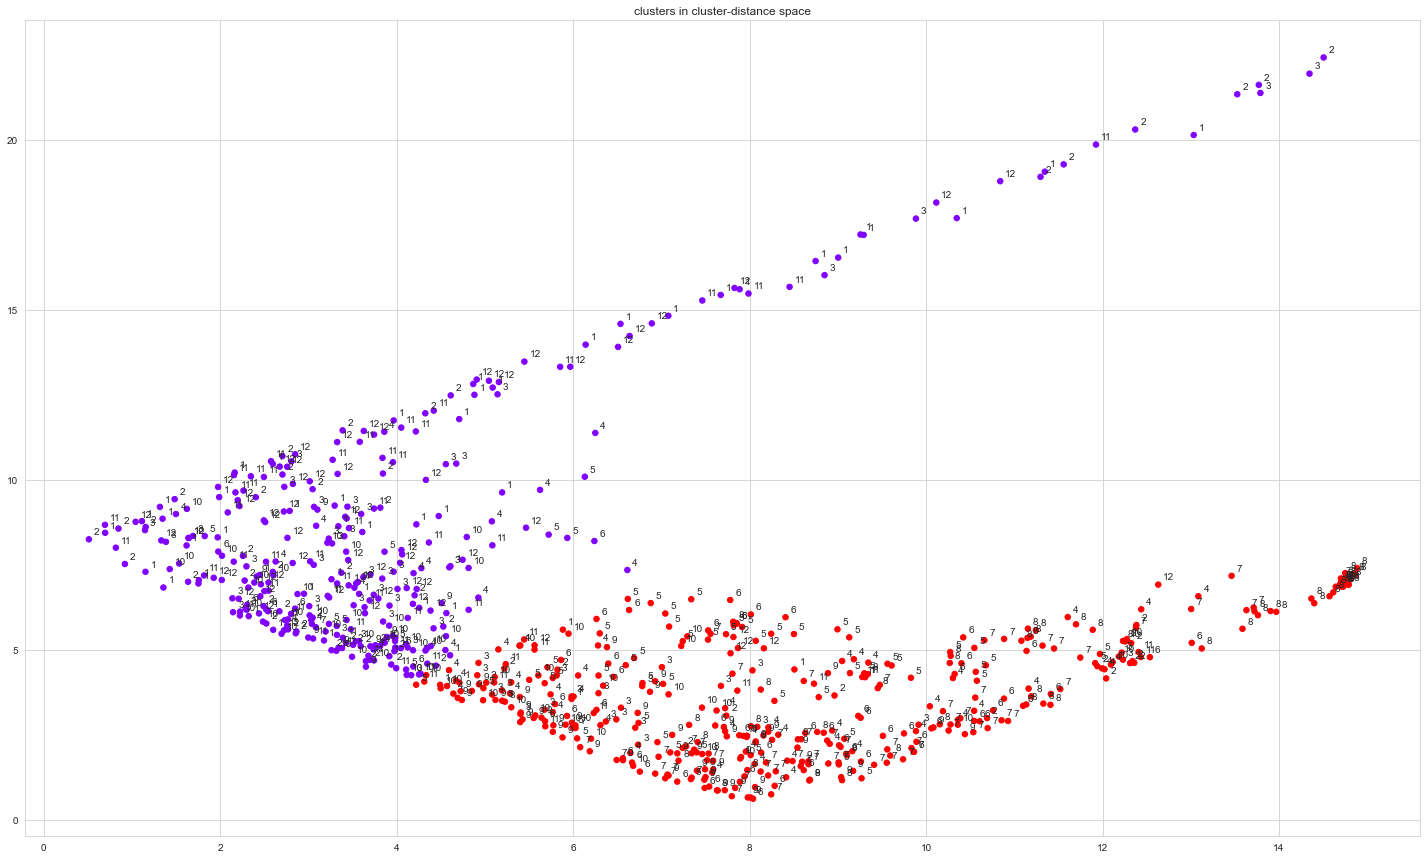

In [50]:
#clustering with n_clusters = 2

nb_cluster = 2
km  = KMeans(n_clusters = nb_cluster)
clust = km.fit(df)
labels = clust.labels_
cldata = clust.transform(df)
fig,ax =  plt.subplots(figsize=(25,15))
ax.set_title("clusters in cluster-distance space")
ax.scatter(cldata[:,0], cldata[:,1], c=labels, marker='o', s=30, cmap=plt.cm.rainbow)
for i, (x, y) in enumerate(cldata):
        date_index = df.index.month[i]
        ax.annotate(date_index, (x, y), xytext=(5, 5), textcoords='offset points')

plt.show

### Recognizing the periods in the year

We observe two ditinguished clusters:

$\bullet$ The blue one comprising mostly months 1,2,3,10,11,12 corresponding nearly to Winter-Autumn an end of summer season in wich the amount of cold may lead to a greater consumption of energy

$\bullet$ The red one comprising mostly months 4,5,6,7,8 corresponding to Spring-Summer with less consumption

## 3 . Distribution of hourly consumption distribution

In [51]:
d_test = data.asfreq('H').loc["2007-12":"2008-02"]

In [52]:
d_test['hour'] = d_test.index.hour
hour_dict = {}

for hour in range(24):
    hour_dict [hour] = d_test[d_test['hour'] == hour]['global_active_power']

In [53]:
X = hour_dict[7].values
kstest_result = kstest(X, norm.cdf)
test_statistic = kstest_result.statistic
p_value = kstest_result.pvalue
print("Statistique de test :", test_statistic)
print("p_value :", p_value)

Statistique de test : 0.5800416379095963
p_value : 1.383565823851214e-29


In [54]:
pvalues = {}

for hour in range(24):
    _, p_value = stats.kstest(hour_dict[hour].values, 'norm')
    pvalues[hour] = p_value

    
print(f'les p-valeurs du test de Kolmogorov par heure sont données par:\n')
pvalues

les p-valeurs du test de Kolmogorov par heure sont données par:



{0: 5.0790773088324946e-30,
 1: 6.2101831894617335e-30,
 2: 5.0790773088324946e-30,
 3: 4.152668802247081e-30,
 4: 5.0790773088324946e-30,
 5: 6.2101831894617335e-30,
 6: 2.7733145740723928e-30,
 7: 1.383565823851214e-29,
 8: 1.7079747247309247e-42,
 9: 1.6338792712552464e-40,
 10: 3.042877585780586e-45,
 11: 5.032182485326005e-45,
 12: 1.5870329553820296e-33,
 13: 3.672266664643111e-30,
 14: 5.496680083396996e-34,
 15: 4.152668802247081e-30,
 16: 4.152668802247081e-30,
 17: 5.0790773088324946e-30,
 18: 5.0790773088324946e-30,
 19: 1.6379554873867467e-58,
 20: 1.1382182399006898e-49,
 21: 1.058241452375627e-57,
 22: 1.450037717698983e-36,
 23: 6.2101831894617335e-30}

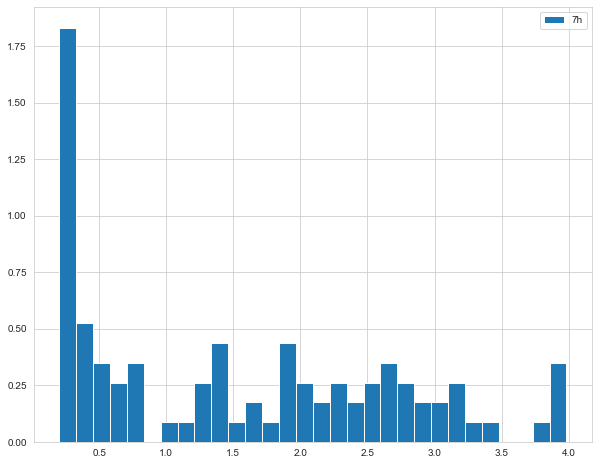

In [55]:
### Visualising the hour distribution

most_gaussian = 7
plt.figure(figsize = (10,8))
plt.hist(hour_dict[most_gaussian], bins = 30, density = True, label = f'{most_gaussian}h')
plt.legend()
plt.title('Hourly distribution of power consumption data in the period 2007-12:2008-02"')
plt.show()

## 4. Weather Influence

In [56]:
## Building Train and Test datasets

train,test = data.loc["2007":"2009"].asfreq('3H'),data.loc["2010"].asfreq('3H')


 	 +++++ Correlation matrix between features +++++


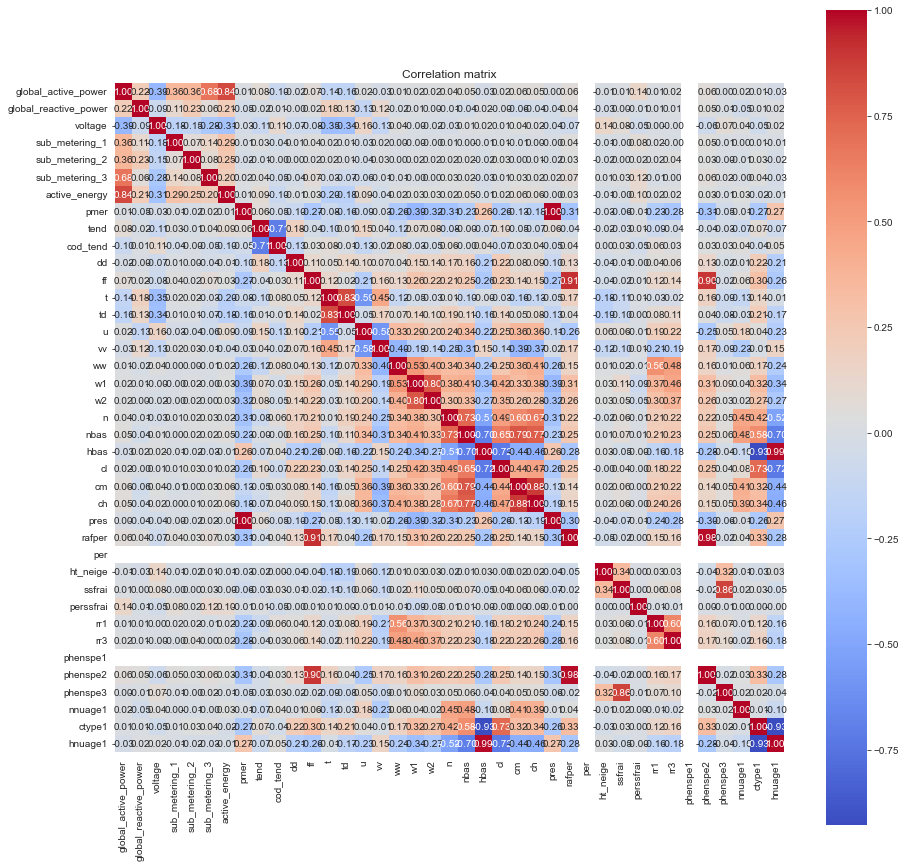

In [57]:
### Correlation Matrix

plt.figure(figsize = (15,15))
corr_mat = train.corr()
print("\n \t +++++ Correlation matrix between features +++++")
sns.heatmap(corr_mat, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.title("Correlation matrix")
plt.show()

In [58]:
## Training

X_train = train.iloc[:,7:]
y_train = train["global_active_power"]

X_test = test.iloc[:,7:]
y_test = test["global_active_power"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
## Prediction with Linear Regression model

reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)

mse = metrics.mean_squared_error(y_pred,y_test)
mae = metrics.mean_absolute_error(y_pred,y_test)

In [60]:
print(f"Mean squared Error: {mse}\n")
print(f"Mean absolute Error: {mae}")

Mean squared Error: 0.6965330060475535

Mean absolute Error: 0.6638008468120133


In [61]:
pred = pd.DataFrame(y_pred,index = y_test.index).head(23)

In [62]:
print(f'Predicted values: \n {pred}')

print(f'\n real values: \n {y_test.head(23)}')

Predicted values: 
                             0
date                         
2010-01-01 00:00:00  1.210893
2010-01-01 03:00:00  1.423014
2010-01-01 06:00:00  1.405657
2010-01-01 09:00:00  1.740483
2010-01-01 12:00:00  1.490647
2010-01-01 15:00:00  1.785731
2010-01-01 18:00:00  1.725541
2010-01-01 21:00:00  1.578264
2010-01-02 00:00:00  1.107793
2010-01-02 03:00:00  1.461874
2010-01-02 06:00:00  1.113375
2010-01-02 09:00:00  1.350389
2010-01-02 12:00:00  1.433336
2010-01-02 15:00:00  1.440277
2010-01-02 18:00:00  1.116037
2010-01-02 21:00:00  1.328642
2010-01-03 00:00:00  1.064946
2010-01-03 03:00:00  1.202514
2010-01-03 06:00:00  0.932074
2010-01-03 09:00:00  1.271046
2010-01-03 12:00:00  0.909905
2010-01-03 15:00:00  1.449157
2010-01-03 18:00:00  1.391822

 real values: 
 date
2010-01-01 00:00:00    1.790000
2010-01-01 03:00:00    0.630000
2010-01-01 06:00:00    0.566000
2010-01-01 09:00:00    0.644000
2010-01-01 12:00:00    0.674000
2010-01-01 15:00:00    0.902000
2010-01-01 18:00